In [116]:
import numpy as np
import matplotlib.pyplot as plt
import interpolation
import music
import grid_search
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def calculate_angle(I1, Q1, I2, Q2):
    dot_product = I1 * I2 + Q1 * Q2
    cos_theta = np.clip(dot_product, -1.0, 1.0)

    theta = np.arccos(cos_theta)
    cross_product = I1 *Q2 - Q1 * I2
    if cross_product > 0:
        theta = theta
    else:
        theta = -theta
    return theta

def normalization(ant_I, ant_Q):
    # 计算幅度
    amplitude = np.sqrt(ant_I**2 + ant_Q**2)
    # 归一化 I 和 Q 分量
    norm_I = ant_I / amplitude
    norm_Q = ant_Q / amplitude
    return norm_I, norm_Q

def ant_IQ_norm(ant_I_array, ant_Q_array):
    for i in range(len(ant_I_array)):
        ant_I_array[i], ant_Q_array[i] = normalization(ant_I_array[i], ant_Q_array[i])
    return ant_I_array, ant_Q_array

data = np.load('SCuM_darkroom_experiment/10_data.npz')

I_data_array = data['I_data'][:40]
Q_data_array = data['Q_data'][:40]
rssi_array = data['rssi'][:40]
music_angle_array = data['music_angle'][:40]
grid_search_angle_array = data['grid_search_angle'][:40]
angle_change_1us_array = data['angle_change_1us'][:40]

music_angle_list = []
grid_search_angle_list = []


for i in range(len(I_data_array)):
    I_data = I_data_array[i]
    Q_data = Q_data_array[i]
    rssi = rssi_array[i]

    reference_I = I_data[:8]
    reference_Q = Q_data[:8]
    reference_I, reference_Q = ant_IQ_norm(reference_I, reference_Q)
    

    ref_theta_array = np.zeros(7)
    for j in range(7):
        ref_theta_array[j] = calculate_angle(reference_I[j], reference_Q[j], reference_I[j+1], reference_Q[j+1])

    angle_change_1us = np.mean(ref_theta_array)
    
    music_angle = music.cal_angle_with_music(I_data, Q_data, angle_change_1us)

    I_data_copy = np.copy(I_data)
    Q_data_copy = np.copy(Q_data)
    grid_search_angle = grid_search.cal_angle_with_grid_search(I_data_copy, Q_data_copy, angle_change_1us)

    music_angle_list.append(music_angle)
    grid_search_angle_list.append(grid_search_angle)

In [117]:
angle_list = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]

sample_number = 47
music_result = np.zeros((11,sample_number))
grid_search_result = np.zeros((11,sample_number))
for index in range(len(angle_list)):
    data = np.load('SCuM_darkroom_experiment/{}_data.npz'.format(angle_list[index]))
    I_data_array = data['I_data'][:sample_number]
    Q_data_array = data['Q_data'][:sample_number]
    rssi_array = data['rssi'][:sample_number]
    music_angle_array = data['music_angle'][:sample_number]
    grid_search_angle_array = data['grid_search_angle'][:sample_number]

    music_result[index,:] = music_angle_array
    grid_search_result[index,:] = grid_search_angle_array

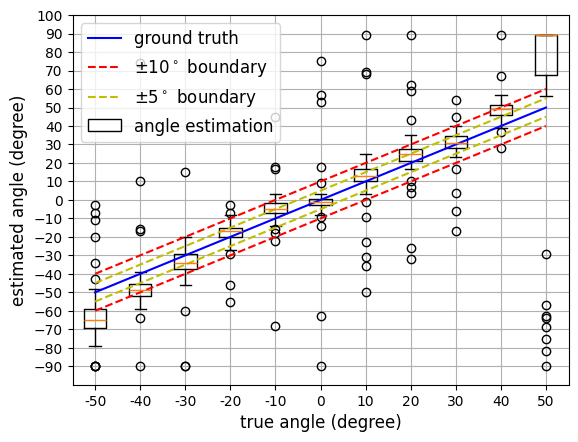

In [118]:
plt.figure()
plt.boxplot(grid_search_result.T)
plt.xticks(ticks=range(1, len(angle_list)+1), labels=angle_list)
plt.xlabel('true angle (degree)', fontsize=12)
plt.ylabel('estimated angle (degree)', fontsize=12)
plt.ylim(-100, 100)
plt.yticks(np.arange(-90, 101, 10))
plt.plot([i/10+6 for i in angle_list], angle_list, c='b', label='perfect')
plt.plot([i/10+6 for i in angle_list], [i + 10 for i in angle_list], c='r', linestyle = '--', label='10 degree boundary')
plt.plot([i/10+6 for i in angle_list], [i - 10 for i in angle_list], c='r', linestyle = '--', label='10 degree boundary')
plt.plot([i/10+6 for i in angle_list], [i + 5 for i in angle_list], c='y', linestyle = '--', label='5 degree boundary')
plt.plot([i/10+6 for i in angle_list], [i - 5 for i in angle_list], c='y', linestyle = '--', label='5 degree boundary')
plt.grid(True)

legend_elements = [
    Line2D([0], [0], color='b', label='ground truth'),
    Line2D([0], [0], color='r', linestyle='--', label='$\pm 10^\circ$ boundary'),
    Line2D([0], [0], color='y', linestyle='--', label='$\pm 5^\circ$ boundary'),
    Patch(edgecolor='black', facecolor='w', linewidth=1, label='angle estimation')
]

plt.legend(handles=legend_elements, fontsize=12)
plt.savefig('result.svg', format='svg')
plt.show()

In [119]:
print(grid_search_result.shape)

for i in range(len(angle_list)):
    true_angle = angle_list[i]
    for j in range(len(grid_search_result[i])):
        #grid_search_result[i][j] = np.abs(grid_search_result[i][j] - true_angle)
        grid_search_result[i][j] = grid_search_result[i][j] - true_angle

(11, 47)


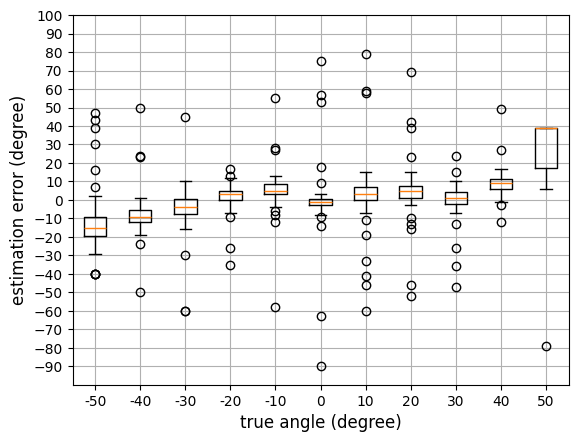

In [120]:
  

plt.figure()
plt.boxplot(grid_search_result.T)
plt.xticks(ticks=range(1, len(angle_list)+1), labels=angle_list)
plt.xlabel('true angle (degree)', fontsize=12)
plt.ylabel('estimation error (degree)', fontsize=12)
plt.ylim(-100, 100)
plt.yticks(np.arange(-90, 101, 10))
plt.grid(True)

#plt.legend(fontsize=12)
plt.savefig('error_result.svg', format='svg')
plt.show()

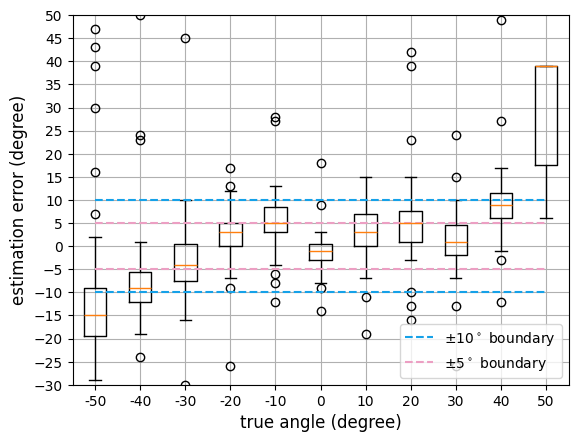

In [144]:
ten_degree_color = "#15a1e8"
five_degree_color = "#ec9fc3"

plt.figure()
plt.boxplot(grid_search_result.T, showfliers=True)
plt.xticks(ticks=range(1, len(angle_list)+1), labels=angle_list)
plt.xlabel('true angle (degree)', fontsize=12)
plt.ylabel('estimation error (degree)', fontsize=12)
plt.plot((1, 11), (5,5), linestyle='--', color=five_degree_color)
plt.plot((1, 11), (-5,-5), linestyle='--', color=five_degree_color)
plt.plot((1, 11), (10,10), linestyle='--', color=ten_degree_color)
plt.plot((1, 11), (-10,-10), linestyle='--', color=ten_degree_color)
plt.ylim(-30, 50)
plt.yticks(np.arange(-30, 51, 5))
plt.grid(True)

legend_elements = [
    Line2D([0], [0], color=ten_degree_color, linestyle='--', label='$\pm 10^\circ$ boundary'),
    Line2D([0], [0], color=five_degree_color, linestyle='--', label='$\pm 5^\circ$ boundary'),
]

plt.legend(handles=legend_elements, fontsize=10)
plt.savefig('error_result.svg', format='svg')
plt.show()